In [27]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [28]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# # 클래스 0과 1에 해당하는 데이터만 선택 (test set)
# test_mask = np.isin(y_test_full, selected_classes)
# X_test_filtered = X_test_gray[test_mask.squeeze()]
# y_test_filtered = y_test_full[test_mask.squeeze()]


# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 400
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)


y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


Training set size: 320
Test set size: 80
Sampled train labels: [0. 1.]
Sampled test labels: [0. 1.]


In [29]:
X_train.shape

(320, 32, 32)

In [30]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [31]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [32]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 2880, 1.0: 320}


In [33]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 720, 1.0: 80}


In [34]:
X_train.shape

(320, 64, 16)

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(attention):
    """
    Visualize the attention coefficients as a bar plot.
    
    Parameters:
        attention (torch.Tensor): Attention weights of shape (batch_size, heads, query_len, key_len).
    """
    # Compute the average attention across heads and batch
    avg_attention = attention.mean(dim=1).mean(dim=0).detach().cpu().numpy()  # Shape: [4, 4]
    
    avg_attention = (avg_attention - avg_attention.min()) / (avg_attention.max() - avg_attention.min())
    
    # Reshape the attention map into (2, 2) patches
    patch_size = 8
    num_patches = avg_attention.shape[0] // patch_size
    reshaped_attention = avg_attention.reshape(num_patches, patch_size, num_patches, patch_size)
    
    # Aggregate into (2x2) patches by taking the mean
    aggregated_attention = reshaped_attention.sum(axis=(1, 3))  # Shape: [2, 2]
    
    # Flatten for bar plot
    patch_labels = [f"Patch ({i}, {j})" for i in range(aggregated_attention.shape[0]) 
                    for j in range(aggregated_attention.shape[1])]
    flattened_attention = aggregated_attention.flatten()
    
    # Plot the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(patch_labels, flattened_attention, color='orange', alpha=0.7, edgecolor='black')
    plt.title("Sum of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Self-Attention and Binary Classifier from previous code
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into multiple heads
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        print(f'shape {attention.shape}')
        visualize_attention(attention)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Classifier model
class SimpleSelfAttentionClassifier(nn.Module):
    def __init__(self, embed_size=16, heads=2, num_classes=10):
        super(SimpleSelfAttentionClassifier, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.fc = nn.Linear(embed_size * 64, num_classes)  # 49 is the sequence length in X_train

    def forward(self, x):
        attention_output = self.attention(x, x, x)
        attention_output = attention_output.flatten(start_dim=1)  # Flatten to feed into classifier
        out = self.fc(attention_output)
        return out

In [37]:
# Model, loss, optimizer
model = SimpleSelfAttentionClassifier(embed_size=16, heads=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: attention.values.weight
Shape: torch.Size([8, 8])
Number of parameters: 64
--------------------------------------------------
Parameter name: attention.keys.weight
Shape: torch.Size([8, 8])
Number of parameters: 64
--------------------------------------------------
Parameter name: attention.queries.weight
Shape: torch.Size([8, 8])
Number of parameters: 64
--------------------------------------------------
Parameter name: attention.fc_out.weight
Shape: torch.Size([16, 16])
Number of parameters: 256
--------------------------------------------------
Parameter name: attention.fc_out.bias
Shape: torch.Size([16])
Number of parameters: 16
--------------------------------------------------
Parameter name: fc.weight
Shape: torch.Size([10, 1024])
Number of parameters: 10240
--------------------------------------------------
Parameter name: fc.bias
Shape: torch.Size([10])
Number of parameters: 10
--------------------------------------------------
Total number of trainable paramet

shape torch.Size([2, 2, 64, 64])


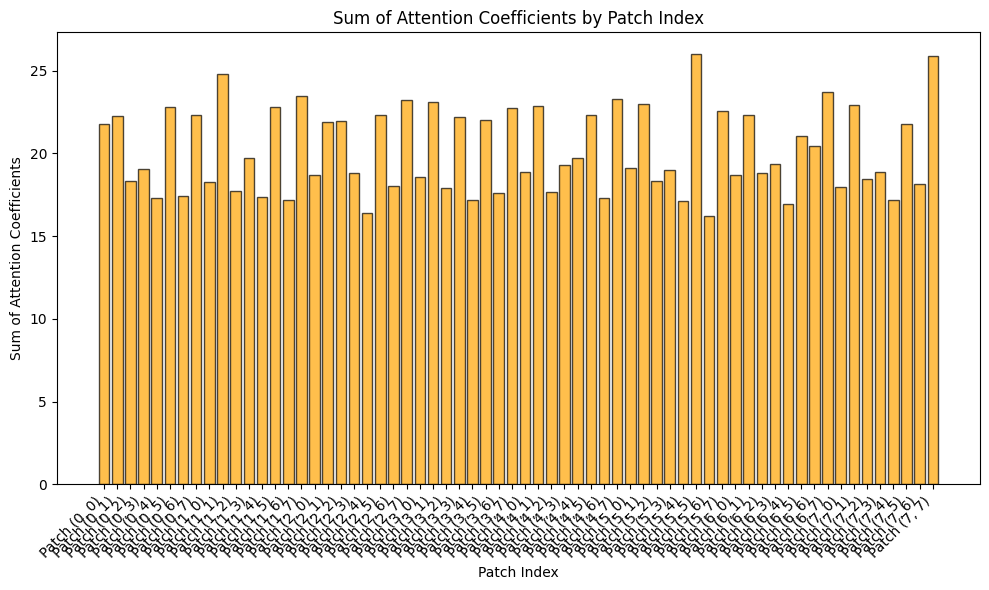

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 64, 16]             272
     SelfAttention-2               [-1, 64, 16]               0
            Linear-3                   [-1, 10]          10,250
Total params: 10,522
Trainable params: 10,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.04
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [39]:
from torchsummary import summary
summary(model, input_size=(64, 16))  # (sequence_length, embed_size)


In [40]:
# def binary_accuracy(preds, y):
#     """
#     Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#     """

#     #round predictions to the closest integer
#     rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
#     correct = (rounded_preds == y).float() #convert into float for division 
#     acc = correct.sum() / len(correct)
#     return acc

In [41]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

  0%|          | 0/20 [00:00<?, ?it/s]

shape torch.Size([320, 2, 64, 64])


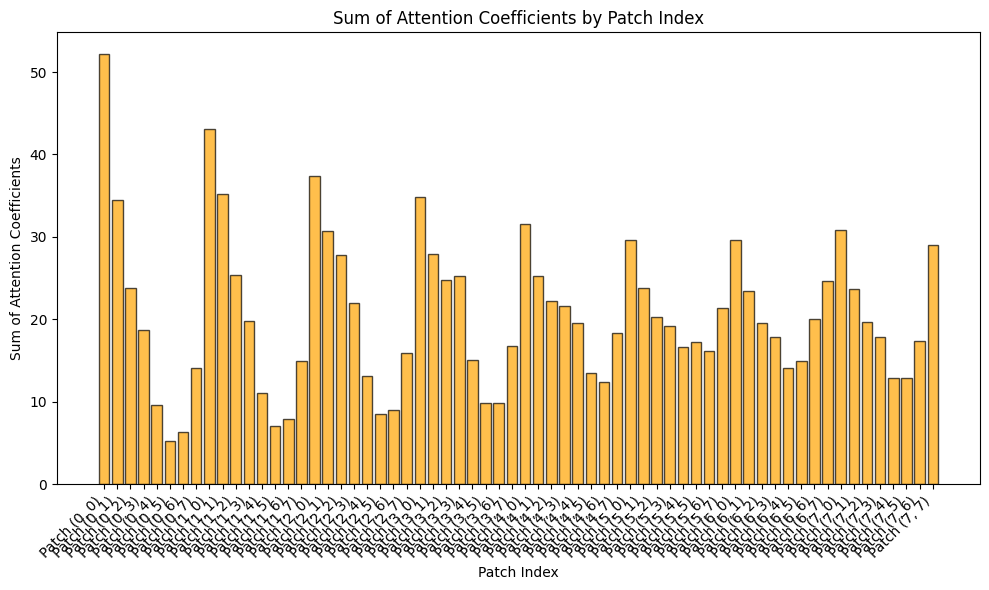

  5%|▌         | 1/20 [00:00<00:07,  2.39it/s]

tensor([1, 7, 7, 1, 7, 1, 7, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 7, 7, 1, 7, 7, 7,
        7, 1, 1, 7, 7, 7, 1, 7, 1, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 1, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 1, 7, 1, 7, 1, 7, 7, 7, 1, 7, 7, 7, 7, 1, 7, 7, 7,
        7, 7, 7, 7, 1, 7, 7, 1, 7, 1, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 1, 1,
        7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 1, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7,
        7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7,
        7, 7, 1, 1, 7, 7, 7, 7, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 7,
        7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 7, 7, 7, 1, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 1, 7, 1, 7,
        7, 1, 1, 1, 7, 1, 7, 7, 1, 1, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 1,
        7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 7, 7,
        1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 1,

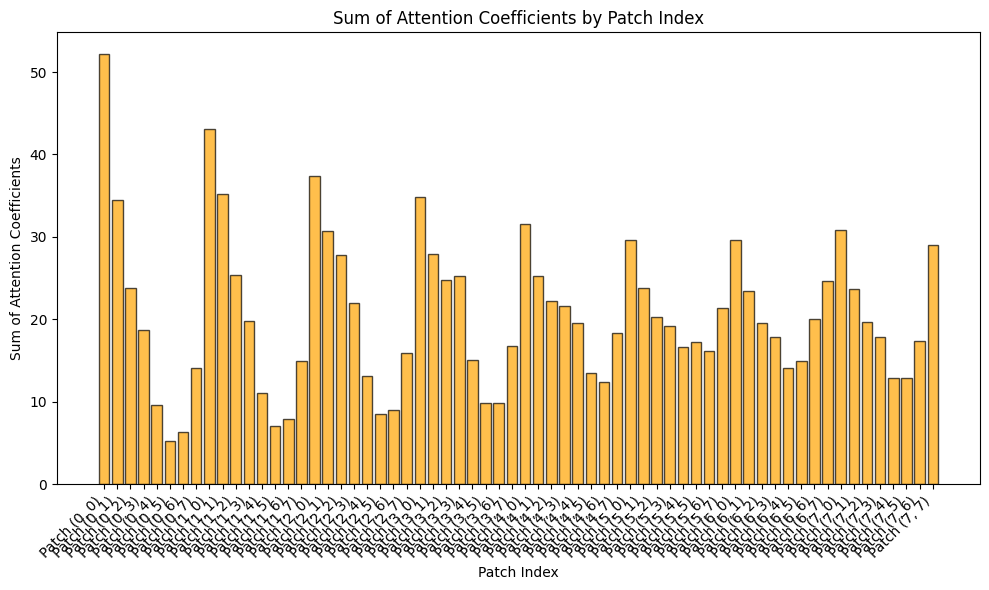

 10%|█         | 2/20 [00:00<00:07,  2.36it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

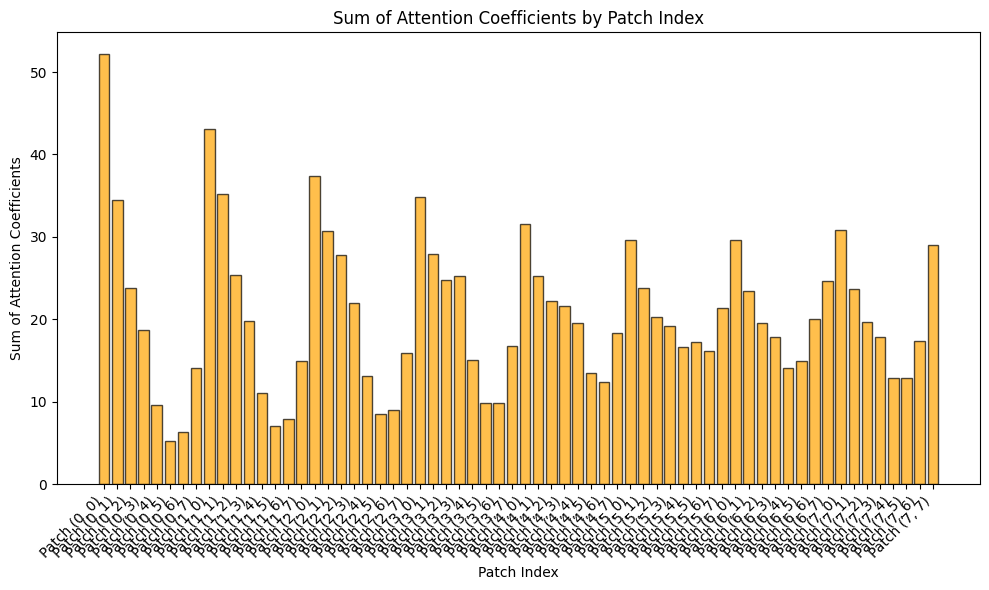

 15%|█▌        | 3/20 [00:01<00:07,  2.36it/s]

tensor([8, 8, 4, 8, 8, 4, 8, 8, 8, 8, 4, 4, 8, 8, 8, 8, 4, 4, 8, 8, 4, 8, 8, 4,
        8, 8, 4, 8, 4, 8, 4, 4, 8, 8, 8, 4, 8, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        4, 8, 4, 8, 8, 4, 8, 8, 8, 8, 8, 4, 4, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8,
        8, 4, 8, 8, 4, 4, 8, 4, 4, 4, 8, 8, 4, 8, 8, 8, 8, 8, 8, 4, 4, 8, 4, 8,
        4, 4, 4, 8, 4, 4, 8, 4, 8, 4, 8, 4, 4, 8, 4, 8, 8, 8, 4, 8, 8, 4, 8, 8,
        8, 8, 8, 8, 4, 4, 8, 4, 4, 8, 4, 4, 4, 4, 8, 4, 8, 8, 8, 8, 4, 8, 4, 4,
        8, 8, 4, 4, 4, 4, 8, 8, 8, 4, 8, 8, 8, 4, 4, 8, 8, 8, 8, 8, 4, 8, 4, 4,
        8, 4, 8, 8, 4, 8, 8, 4, 8, 4, 4, 4, 8, 8, 4, 8, 8, 8, 8, 8, 4, 8, 4, 8,
        8, 8, 8, 8, 4, 8, 4, 4, 8, 8, 8, 8, 8, 4, 4, 8, 8, 8, 4, 8, 8, 8, 8, 4,
        8, 8, 8, 8, 8, 4, 8, 4, 8, 4, 4, 8, 4, 8, 4, 8, 8, 8, 4, 4, 8, 4, 4, 8,
        8, 8, 4, 4, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 8, 4, 8, 4, 4,
        8, 8, 8, 4, 8, 4, 4, 8, 8, 8, 4, 4, 8, 4, 8, 4, 4, 4, 4, 8, 8, 4, 8, 8,
        4, 8, 4, 4, 4, 8, 8, 8, 4, 4, 8,

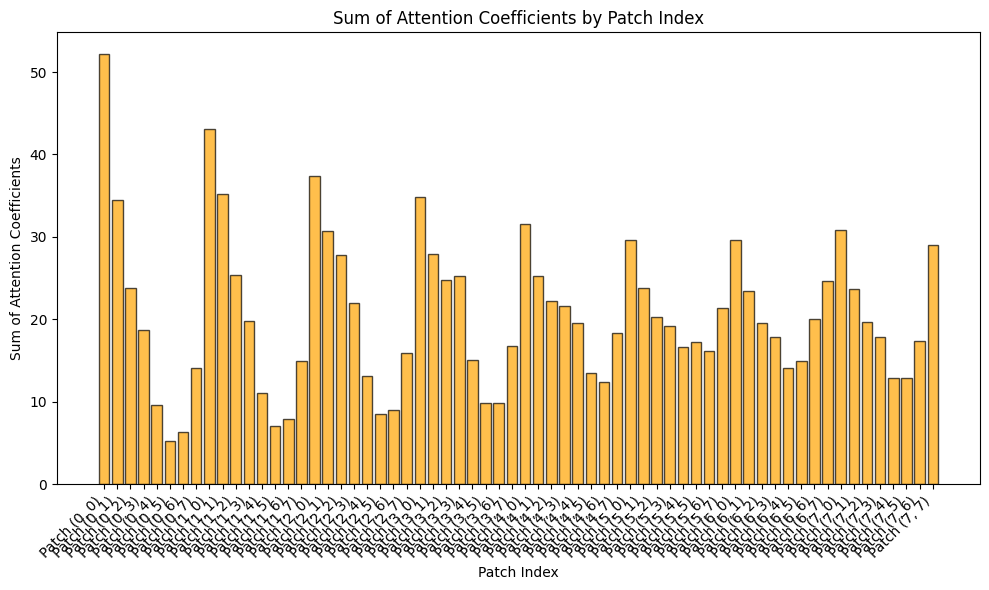

 20%|██        | 4/20 [00:01<00:06,  2.36it/s]

tensor([8, 9, 8, 9, 8, 8, 9, 9, 8, 8, 8, 4, 9, 9, 9, 8, 8, 8, 8, 8, 4, 8, 9, 4,
        8, 8, 8, 9, 8, 9, 4, 8, 9, 9, 9, 8, 9, 8, 8, 8, 9, 8, 9, 8, 8, 9, 8, 9,
        8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 9, 9, 8, 4, 9, 9, 9,
        9, 8, 9, 8, 4, 4, 9, 4, 8, 4, 8, 9, 4, 9, 9, 8, 9, 9, 9, 8, 4, 9, 4, 8,
        4, 8, 9, 8, 9, 4, 8, 4, 9, 8, 9, 9, 4, 9, 8, 9, 8, 9, 8, 8, 9, 8, 8, 8,
        9, 9, 8, 8, 4, 9, 8, 4, 4, 9, 4, 8, 8, 8, 9, 8, 9, 8, 9, 8, 4, 8, 4, 9,
        9, 9, 8, 8, 8, 8, 9, 9, 9, 8, 8, 9, 9, 4, 8, 9, 8, 8, 9, 9, 4, 8, 9, 8,
        8, 8, 8, 8, 8, 9, 9, 4, 8, 8, 8, 8, 9, 9, 4, 9, 9, 9, 8, 8, 8, 9, 8, 9,
        9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 8, 9, 4, 8, 8, 9, 9, 4, 8, 8, 8, 9, 4,
        8, 9, 8, 9, 8, 8, 9, 9, 9, 8, 9, 9, 4, 9, 4, 9, 9, 9, 4, 8, 8, 8, 4, 8,
        9, 8, 8, 8, 9, 4, 9, 9, 8, 8, 8, 9, 8, 9, 9, 9, 9, 9, 8, 9, 8, 9, 8, 8,
        9, 8, 8, 8, 9, 8, 8, 9, 9, 9, 8, 8, 8, 9, 9, 9, 8, 4, 8, 8, 9, 8, 8, 9,
        4, 9, 8, 4, 4, 9, 8, 9, 8, 9, 9,

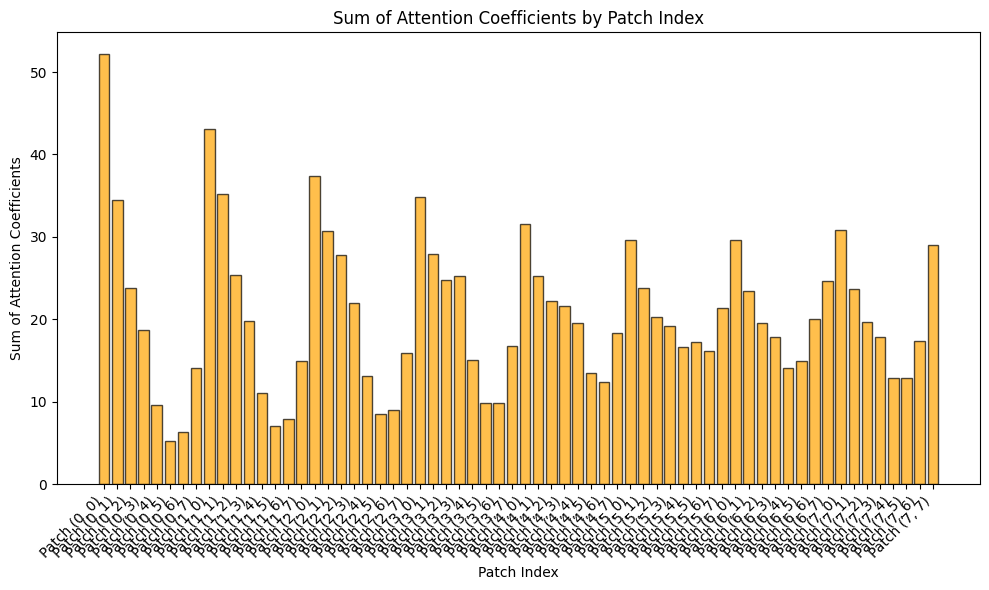

 25%|██▌       | 5/20 [00:02<00:06,  2.35it/s]

tensor([7, 9, 7, 9, 7, 7, 9, 9, 7, 7, 7, 7, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 9, 7,
        7, 7, 7, 9, 7, 9, 7, 7, 9, 9, 7, 7, 9, 7, 7, 7, 9, 7, 9, 9, 7, 9, 9, 9,
        7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 9, 7, 9, 7, 9, 9, 7, 7, 9, 9, 9,
        9, 7, 9, 7, 7, 7, 9, 7, 7, 7, 7, 9, 7, 9, 9, 7, 9, 9, 9, 7, 7, 9, 7, 7,
        7, 7, 7, 7, 9, 7, 7, 7, 9, 7, 9, 9, 7, 9, 7, 9, 7, 9, 7, 7, 9, 7, 7, 9,
        9, 9, 7, 9, 7, 7, 9, 7, 7, 9, 7, 7, 7, 7, 9, 7, 9, 7, 9, 7, 7, 7, 7, 9,
        9, 9, 7, 7, 7, 7, 9, 9, 9, 7, 7, 9, 9, 7, 7, 9, 7, 7, 9, 9, 7, 7, 7, 7,
        7, 7, 9, 7, 7, 9, 9, 7, 7, 7, 7, 7, 9, 9, 7, 9, 9, 9, 7, 7, 7, 9, 7, 9,
        9, 9, 9, 7, 7, 7, 7, 7, 9, 9, 9, 7, 9, 7, 7, 7, 9, 9, 7, 7, 7, 9, 9, 7,
        7, 9, 7, 9, 7, 7, 9, 7, 9, 7, 9, 9, 7, 9, 7, 9, 9, 9, 7, 7, 9, 7, 7, 7,
        9, 7, 7, 7, 9, 3, 9, 9, 7, 7, 7, 9, 7, 9, 9, 9, 9, 9, 7, 9, 7, 9, 7, 7,
        9, 7, 7, 7, 9, 7, 7, 9, 9, 9, 7, 7, 7, 7, 9, 7, 7, 7, 7, 9, 9, 7, 7, 7,
        3, 9, 7, 7, 7, 9, 7, 9, 7, 9, 9,

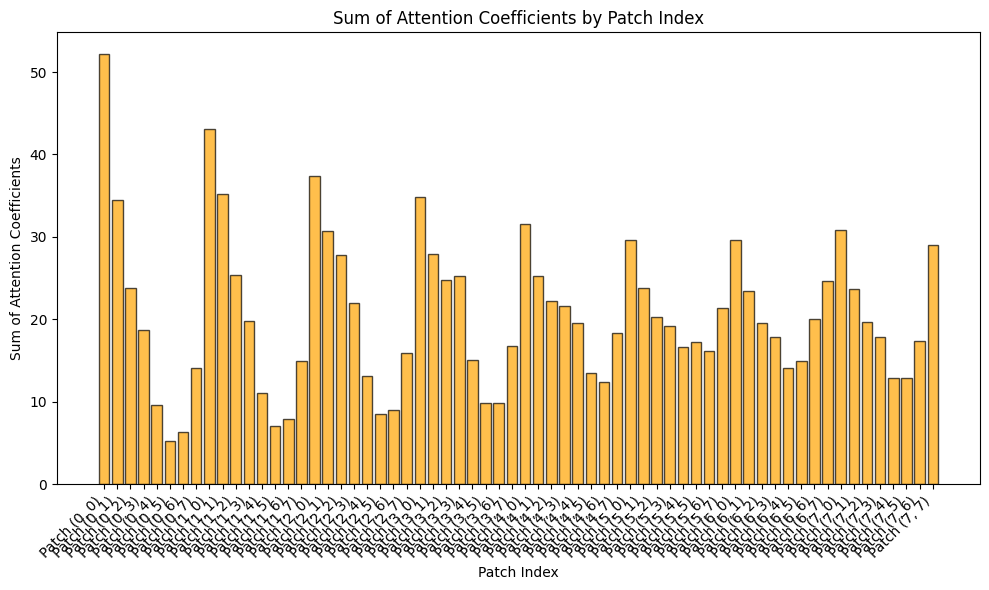

 30%|███       | 6/20 [00:02<00:06,  2.33it/s]

tensor([7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9,
        7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 9, 7, 7, 9, 3, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 9, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 9, 9, 7, 7, 7, 7, 9, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 9, 9, 9, 7, 7, 7, 9, 7, 7,
        7, 7, 9, 7, 7, 7, 7, 7, 7, 9, 9, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7,
        9, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        3, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7,

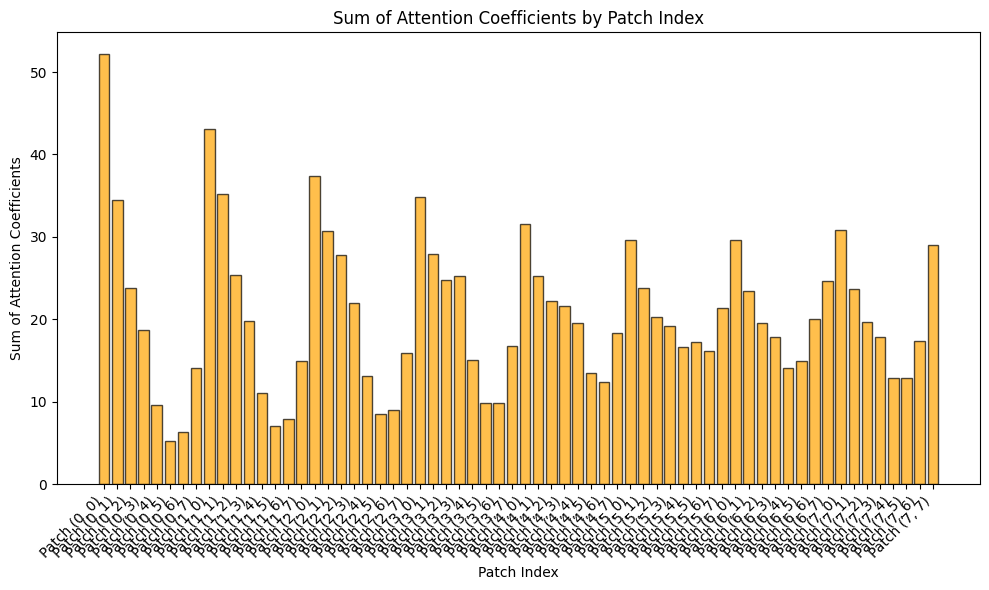

 35%|███▌      | 7/20 [00:03<00:07,  1.73it/s]

tensor([1, 7, 7, 7, 7, 1, 7, 9, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 1, 7, 7, 7, 7, 3, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 3, 7, 3, 7, 7, 3, 9, 7, 7, 7, 7, 9, 7, 3, 9, 3, 7,
        7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 1, 3, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 9, 9, 7, 7, 7, 7, 9, 7, 7, 9, 7, 7, 7, 7, 3, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 9, 7, 9, 7, 7, 7, 9, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 1, 3, 1, 7, 7, 7, 3, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 3, 7,
        7, 7, 1, 1, 7, 3, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 1, 7, 7, 9, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        3, 7, 7, 7, 7, 7, 1, 9, 7, 7, 1,

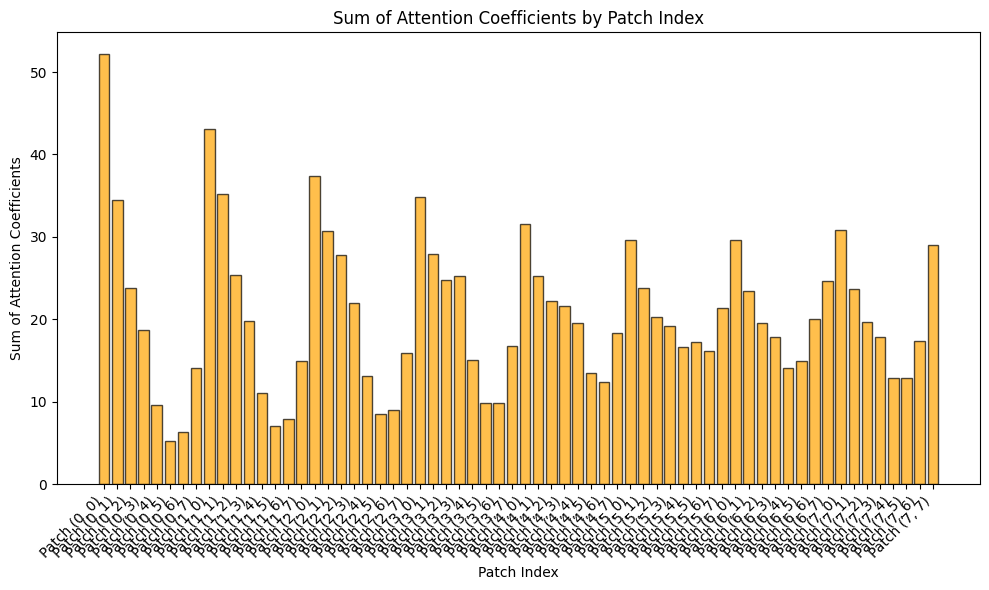

 40%|████      | 8/20 [00:03<00:06,  1.89it/s]

tensor([1, 1, 1, 1, 1, 1, 7, 9, 7, 1, 1, 3, 7, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 7,
        7, 1, 3, 1, 1, 1, 3, 7, 9, 9, 7, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 7, 1, 9,
        1, 1, 7, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 3, 1, 9, 9,
        7, 1, 1, 1, 3, 1, 7, 3, 1, 3, 1, 1, 3, 9, 1, 1, 1, 1, 9, 1, 3, 9, 3, 1,
        3, 1, 7, 1, 7, 3, 7, 3, 9, 1, 1, 7, 3, 9, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1,
        7, 1, 1, 1, 3, 7, 1, 7, 7, 7, 3, 7, 7, 1, 9, 1, 1, 7, 9, 1, 3, 1, 3, 7,
        7, 7, 1, 7, 1, 1, 9, 9, 7, 1, 1, 1, 9, 3, 7, 9, 7, 1, 1, 7, 3, 1, 1, 7,
        1, 1, 1, 1, 1, 7, 1, 3, 1, 1, 1, 7, 9, 9, 3, 9, 9, 9, 7, 1, 7, 9, 1, 1,
        1, 1, 9, 1, 7, 1, 1, 7, 1, 9, 9, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 7,
        1, 1, 1, 1, 1, 1, 7, 7, 1, 1, 7, 1, 3, 9, 7, 1, 7, 1, 3, 1, 1, 1, 3, 1,
        9, 1, 1, 1, 1, 3, 1, 7, 1, 1, 1, 9, 1, 1, 9, 1, 1, 7, 1, 9, 1, 1, 3, 1,
        1, 1, 1, 7, 1, 1, 7, 1, 1, 7, 1, 1, 7, 7, 1, 7, 1, 7, 1, 1, 1, 1, 1, 7,
        3, 1, 7, 3, 3, 7, 1, 9, 7, 7, 1,

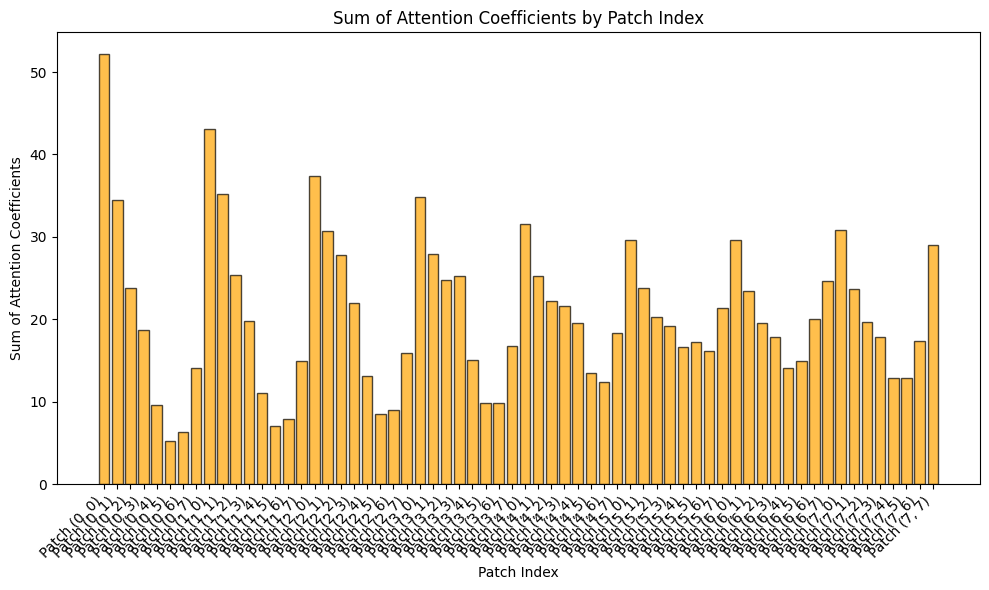

 45%|████▌     | 9/20 [00:04<00:05,  2.00it/s]

tensor([4, 4, 4, 4, 4, 4, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 5, 3, 4, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9,
        4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9,
        4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 9, 4, 4, 4, 4, 9, 4, 3, 9, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 3, 9, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 5, 4, 9, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 9, 9, 4, 4, 4, 5, 9, 4, 4, 9, 4, 4, 4, 9, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 9, 9, 3, 9, 9, 9, 4, 4, 4, 9, 4, 4,
        4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 9, 4, 5, 3, 4, 4, 4, 5, 3, 4, 4, 4, 4, 4,
        4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 4, 4, 5, 3, 4, 4, 4, 3, 4,
        9, 4, 4, 4, 4, 3, 4, 9, 4, 4, 4, 9, 4, 4, 9, 9, 5, 4, 4, 9, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 9, 4, 4, 4,
        3, 4, 4, 3, 4, 4, 4, 9, 4, 4, 4,

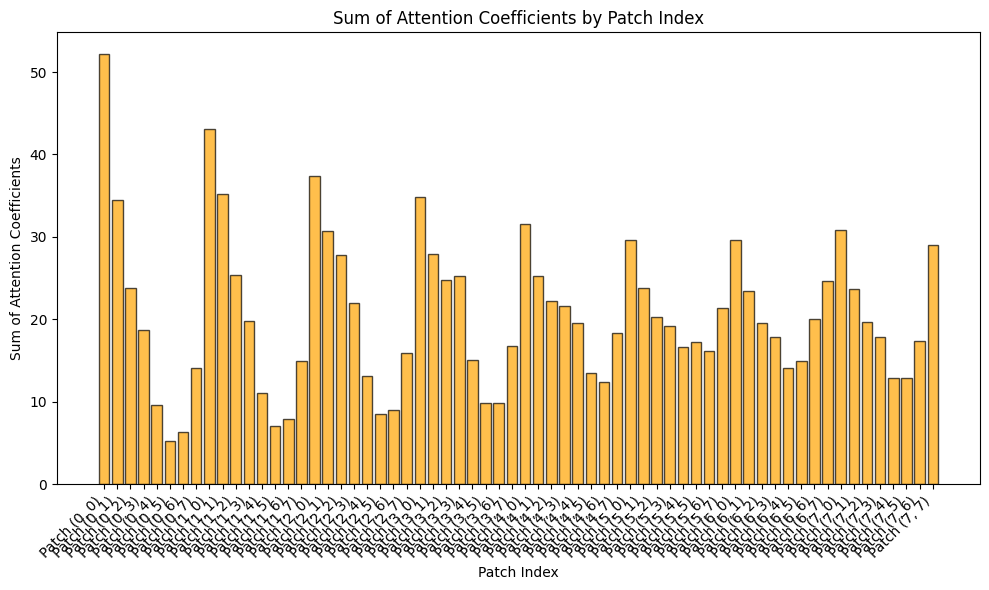

 50%|█████     | 10/20 [00:04<00:04,  2.11it/s]

tensor([4, 4, 4, 5, 4, 4, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 8, 4, 5, 4, 4, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9,
        4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 9, 4, 4, 4, 4, 9, 4, 4, 9, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 4, 9, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 5, 4, 9, 4, 4, 4, 4, 4,
        9, 9, 4, 4, 4, 4, 9, 9, 4, 4, 4, 5, 9, 4, 4, 9, 4, 4, 4, 9, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 9, 9, 4, 4, 4, 4, 4, 9, 9, 4, 9, 9, 9, 4, 4, 4, 9, 4, 4,
        4, 4, 9, 4, 4, 4, 4, 4, 5, 9, 9, 4, 8, 4, 4, 4, 4, 9, 3, 4, 4, 4, 4, 4,
        4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 4, 9, 5, 3, 4, 4, 4, 4, 4,
        9, 4, 4, 4, 4, 3, 4, 9, 4, 4, 4, 9, 4, 4, 9, 9, 8, 4, 4, 9, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 9, 4, 4, 4,
        3, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4,

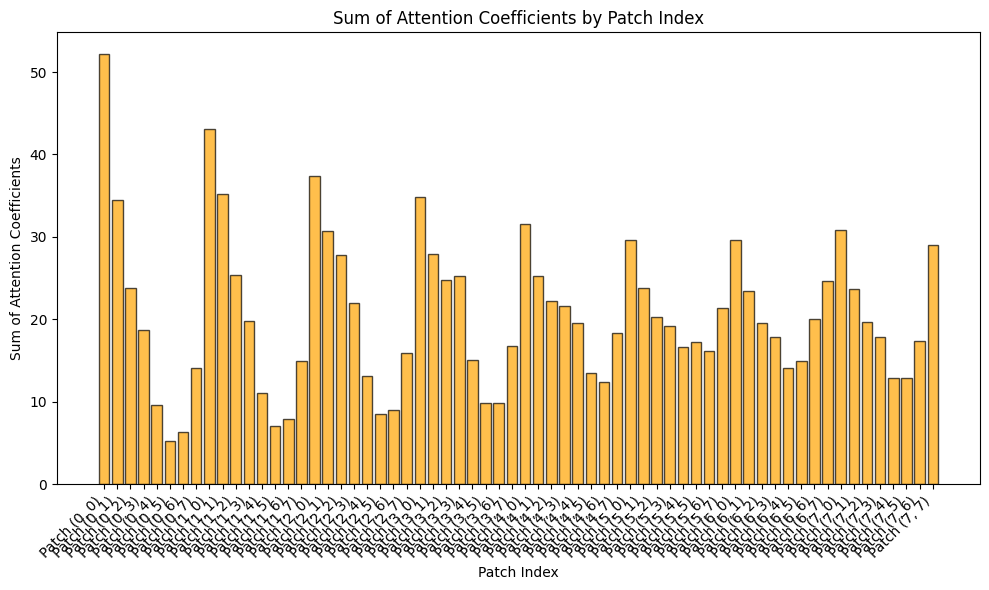

 55%|█████▌    | 11/20 [00:05<00:04,  2.18it/s]

tensor([4, 8, 4, 8, 4, 4, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 8, 4, 9, 4, 4, 9, 9, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9,
        4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 8, 4, 4, 4, 4, 9, 9,
        4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 8, 3, 9, 4, 4, 8, 4, 9, 4, 4, 9, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 4, 9, 4, 4, 4, 8, 4, 4, 9, 4, 4, 4,
        4, 8, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 9, 4, 9, 4, 4, 4, 4, 4,
        9, 9, 4, 4, 4, 4, 9, 9, 4, 4, 4, 8, 9, 4, 4, 9, 4, 4, 8, 9, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 9, 9, 4, 4, 4, 4, 4, 9, 9, 4, 9, 9, 9, 4, 4, 4, 9, 4, 4,
        4, 4, 9, 4, 4, 4, 4, 4, 8, 9, 9, 4, 8, 4, 4, 4, 8, 9, 3, 4, 4, 4, 4, 4,
        4, 9, 4, 8, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 8, 9, 8, 3, 4, 4, 4, 4, 4,
        9, 4, 4, 4, 4, 3, 8, 9, 4, 4, 4, 9, 4, 4, 9, 9, 8, 4, 4, 9, 4, 8, 4, 4,
        8, 4, 4, 4, 4, 4, 4, 4, 8, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 9, 4, 4, 4,
        3, 4, 4, 4, 4, 4, 4, 9, 4, 9, 8,

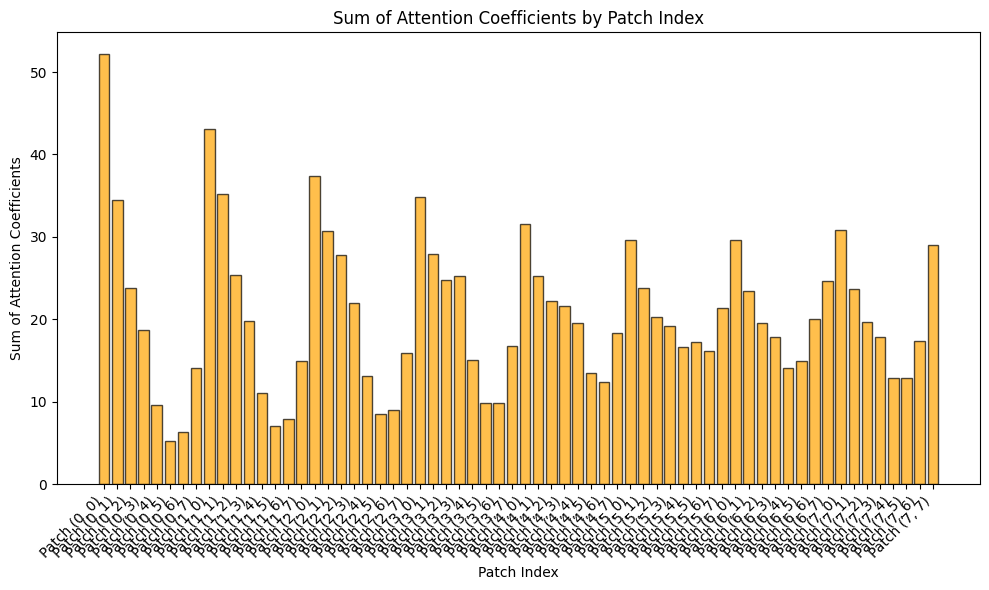

 60%|██████    | 12/20 [00:05<00:03,  2.25it/s]

tensor([4, 8, 4, 8, 4, 4, 9, 9, 4, 4, 4, 4, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 8, 4, 9, 4, 4, 9, 9, 4, 4, 8, 4, 4, 4, 4, 4, 8, 4, 4, 8, 4, 9,
        4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 8, 8, 4, 4, 8, 9, 9,
        4, 4, 8, 4, 4, 4, 9, 4, 4, 4, 4, 8, 3, 9, 8, 4, 8, 4, 9, 4, 4, 9, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 4, 9, 4, 8, 4, 8, 4, 4, 9, 4, 4, 4,
        8, 8, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 9, 4, 9, 4, 4, 4, 4, 4,
        9, 9, 4, 4, 4, 4, 9, 9, 4, 4, 4, 8, 9, 4, 4, 9, 4, 4, 8, 9, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 9, 9, 4, 4, 4, 4, 4, 9, 9, 3, 9, 9, 9, 4, 4, 4, 9, 4, 8,
        8, 4, 9, 4, 4, 4, 4, 4, 8, 9, 9, 4, 8, 4, 4, 4, 8, 9, 3, 4, 4, 8, 4, 4,
        4, 9, 4, 8, 4, 4, 4, 4, 8, 4, 9, 9, 4, 9, 4, 8, 9, 8, 3, 4, 4, 4, 4, 4,
        9, 4, 4, 4, 8, 3, 8, 9, 4, 4, 4, 9, 4, 8, 9, 9, 8, 4, 4, 9, 4, 8, 4, 4,
        8, 4, 4, 4, 8, 4, 4, 8, 8, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 9, 4, 4, 4,
        3, 8, 4, 4, 4, 8, 4, 9, 4, 9, 8,

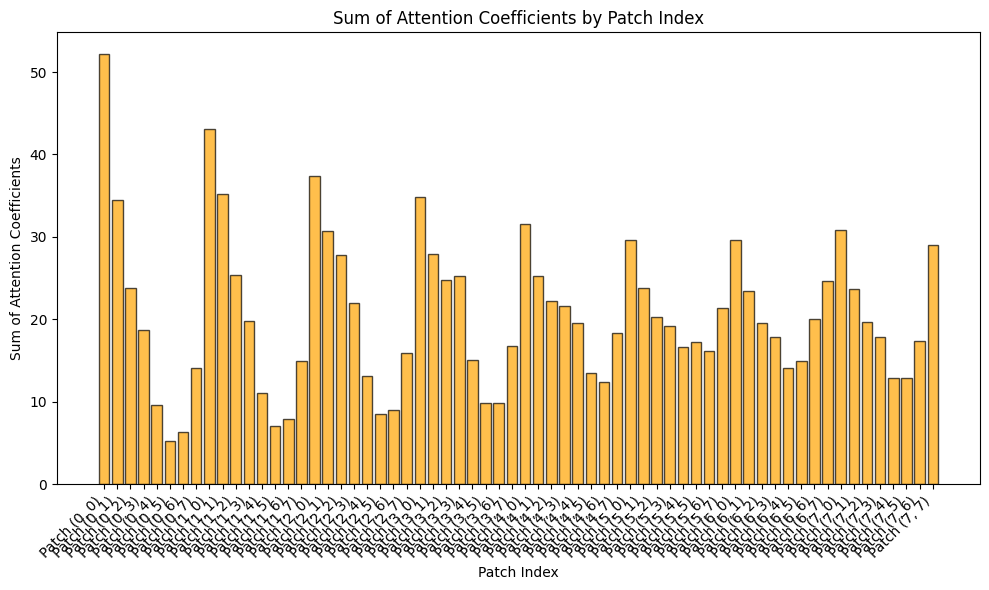

 65%|██████▌   | 13/20 [00:05<00:03,  2.27it/s]

tensor([4, 8, 4, 8, 4, 4, 9, 9, 4, 4, 4, 3, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 8, 4,
        8, 4, 4, 8, 4, 9, 3, 4, 9, 9, 4, 4, 8, 4, 4, 4, 8, 4, 8, 8, 4, 8, 4, 9,
        4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 8, 8, 4, 4, 8, 9, 9,
        8, 4, 8, 4, 4, 4, 9, 3, 4, 3, 4, 8, 3, 9, 8, 4, 8, 4, 9, 4, 3, 9, 3, 4,
        4, 4, 4, 4, 8, 3, 4, 4, 9, 4, 9, 4, 3, 9, 4, 8, 4, 8, 4, 8, 9, 4, 4, 4,
        8, 8, 4, 8, 3, 4, 8, 4, 4, 9, 4, 4, 4, 4, 9, 4, 9, 4, 9, 4, 3, 4, 3, 4,
        9, 9, 4, 4, 4, 4, 9, 9, 8, 4, 4, 8, 9, 4, 4, 9, 4, 8, 8, 9, 3, 4, 4, 4,
        4, 4, 8, 4, 4, 9, 9, 4, 4, 4, 4, 4, 9, 9, 3, 9, 9, 9, 8, 4, 4, 9, 4, 8,
        8, 4, 9, 4, 4, 4, 4, 4, 8, 9, 9, 4, 8, 3, 4, 4, 8, 9, 3, 4, 4, 8, 8, 4,
        4, 9, 4, 8, 4, 4, 8, 4, 8, 4, 9, 9, 4, 9, 4, 8, 9, 8, 3, 4, 8, 4, 3, 4,
        9, 4, 4, 4, 8, 3, 8, 9, 4, 4, 4, 9, 4, 8, 9, 9, 8, 4, 4, 9, 4, 8, 4, 4,
        8, 4, 4, 4, 8, 4, 4, 8, 8, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4, 8, 9, 4, 4, 4,
        3, 8, 4, 3, 4, 8, 4, 9, 4, 9, 8,

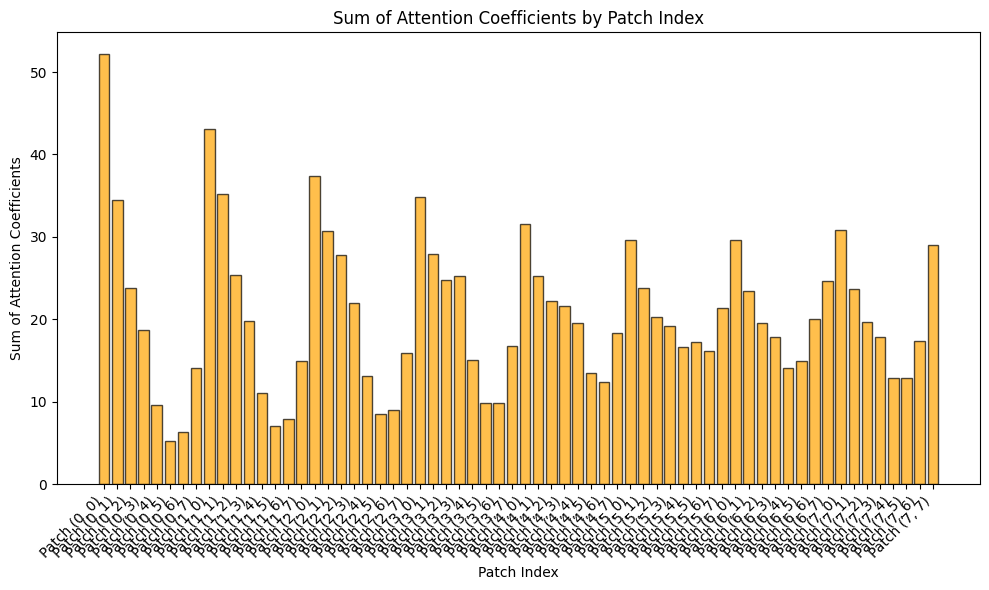

 70%|███████   | 14/20 [00:06<00:02,  2.28it/s]

tensor([4, 8, 4, 8, 4, 3, 9, 9, 4, 4, 4, 3, 8, 8, 8, 4, 3, 4, 4, 4, 3, 7, 8, 7,
        8, 4, 3, 8, 4, 9, 3, 7, 9, 9, 7, 4, 8, 4, 7, 4, 8, 4, 8, 8, 7, 8, 4, 9,
        7, 4, 7, 7, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 8, 8, 4, 3, 8, 9, 9,
        8, 4, 8, 4, 3, 3, 9, 3, 7, 3, 4, 8, 3, 9, 8, 4, 8, 4, 9, 4, 3, 9, 3, 7,
        3, 4, 7, 4, 8, 3, 7, 3, 9, 4, 9, 7, 3, 9, 4, 8, 4, 8, 4, 8, 9, 4, 4, 4,
        8, 8, 4, 8, 3, 7, 8, 3, 4, 9, 3, 7, 7, 4, 9, 4, 9, 7, 9, 4, 3, 7, 3, 7,
        9, 9, 4, 7, 3, 4, 9, 9, 8, 4, 4, 8, 9, 3, 3, 9, 7, 8, 8, 9, 3, 4, 4, 7,
        4, 4, 8, 4, 4, 9, 9, 3, 4, 4, 3, 7, 9, 9, 3, 9, 9, 9, 7, 4, 7, 9, 4, 8,
        8, 4, 9, 4, 4, 4, 7, 7, 8, 9, 9, 4, 8, 3, 4, 4, 8, 9, 3, 4, 4, 8, 8, 4,
        4, 9, 4, 8, 4, 4, 8, 7, 8, 4, 9, 9, 3, 9, 7, 8, 9, 8, 3, 4, 8, 4, 3, 4,
        9, 4, 3, 4, 8, 3, 8, 9, 4, 4, 4, 9, 4, 8, 9, 9, 8, 7, 4, 9, 7, 8, 3, 4,
        8, 4, 7, 7, 8, 3, 7, 8, 8, 9, 3, 4, 7, 7, 9, 7, 4, 7, 4, 8, 9, 3, 4, 7,
        3, 8, 4, 3, 3, 8, 4, 9, 7, 9, 8,

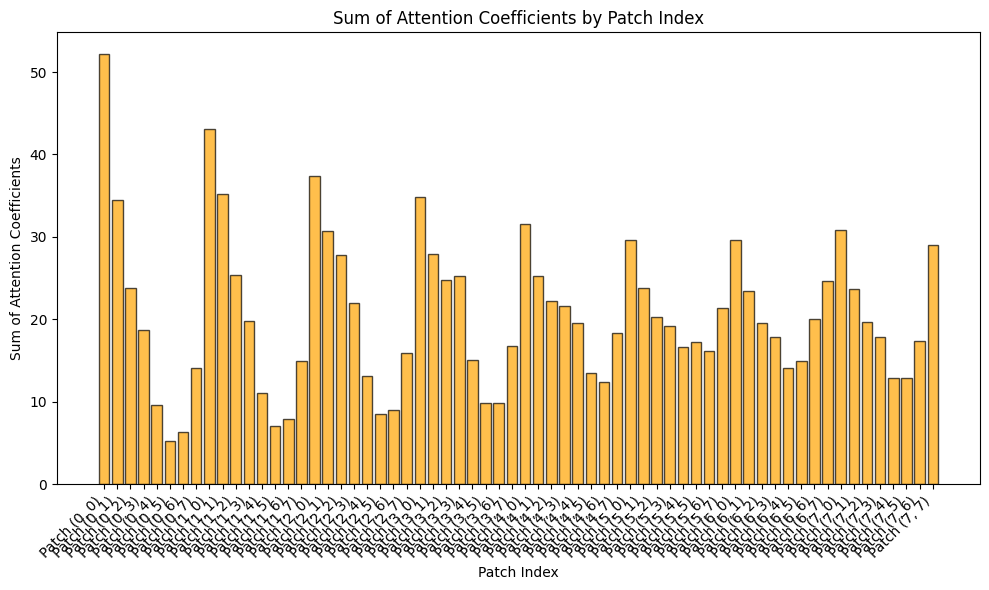

 75%|███████▌  | 15/20 [00:06<00:02,  2.30it/s]

tensor([4, 8, 7, 8, 7, 3, 9, 9, 7, 7, 7, 3, 7, 8, 7, 7, 3, 7, 7, 7, 3, 7, 7, 7,
        7, 7, 3, 9, 7, 9, 3, 7, 9, 9, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9,
        7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 3, 7, 9, 7, 7, 7, 8, 7, 7, 3, 7, 9, 9,
        7, 7, 7, 7, 3, 3, 9, 3, 7, 3, 7, 8, 3, 9, 7, 7, 8, 7, 9, 7, 3, 9, 3, 7,
        3, 7, 7, 7, 7, 3, 7, 3, 9, 7, 9, 7, 3, 9, 7, 7, 7, 9, 7, 7, 9, 3, 7, 7,
        7, 8, 7, 7, 3, 7, 7, 3, 7, 9, 3, 7, 7, 7, 9, 7, 9, 7, 9, 7, 3, 7, 3, 7,
        9, 9, 7, 7, 3, 7, 9, 9, 7, 7, 7, 8, 9, 3, 3, 9, 7, 7, 8, 9, 3, 7, 7, 7,
        7, 7, 7, 7, 7, 9, 9, 3, 7, 3, 3, 7, 9, 9, 3, 9, 9, 9, 7, 7, 7, 9, 7, 8,
        8, 7, 9, 7, 7, 7, 7, 7, 9, 9, 9, 7, 8, 3, 7, 7, 8, 9, 3, 7, 7, 7, 7, 7,
        7, 9, 7, 9, 7, 7, 7, 7, 7, 7, 7, 9, 3, 9, 7, 8, 9, 9, 3, 7, 7, 7, 3, 7,
        9, 7, 3, 3, 7, 3, 8, 9, 7, 4, 7, 9, 7, 7, 9, 9, 9, 7, 7, 9, 7, 8, 3, 7,
        8, 7, 7, 7, 8, 3, 7, 8, 8, 9, 3, 3, 7, 7, 9, 7, 7, 7, 7, 7, 9, 3, 7, 7,
        3, 8, 7, 3, 3, 7, 4, 9, 7, 7, 8,

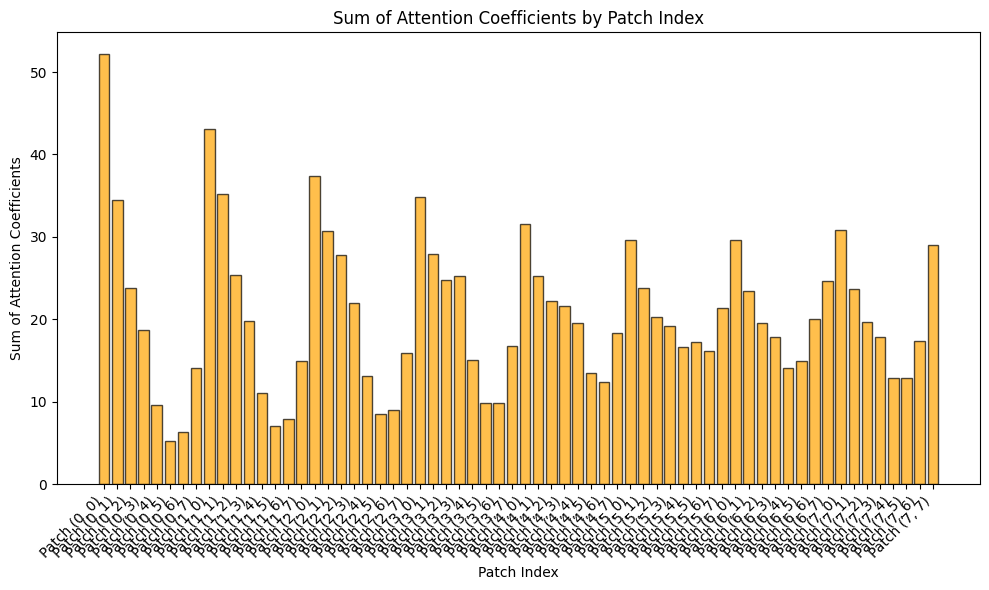

 80%|████████  | 16/20 [00:07<00:01,  2.29it/s]

tensor([7, 9, 7, 9, 7, 3, 9, 9, 7, 7, 7, 3, 7, 8, 7, 7, 3, 7, 7, 7, 3, 7, 7, 7,
        7, 7, 3, 9, 7, 9, 3, 7, 9, 9, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9,
        7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 3, 7, 9, 7, 7, 7, 9, 7, 7, 3, 7, 9, 9,
        7, 7, 7, 7, 3, 3, 9, 3, 7, 3, 7, 8, 3, 9, 7, 7, 9, 7, 9, 7, 3, 9, 3, 7,
        3, 7, 7, 7, 7, 3, 7, 3, 9, 7, 9, 7, 3, 9, 7, 7, 7, 9, 7, 7, 9, 3, 7, 7,
        7, 8, 7, 7, 3, 7, 7, 3, 7, 9, 3, 7, 7, 7, 9, 7, 9, 7, 9, 7, 3, 7, 3, 7,
        9, 9, 7, 7, 3, 7, 9, 9, 7, 7, 7, 9, 9, 3, 3, 9, 7, 7, 8, 9, 3, 7, 7, 7,
        7, 7, 7, 7, 7, 9, 9, 3, 7, 3, 3, 7, 9, 9, 3, 9, 9, 9, 7, 7, 7, 9, 7, 8,
        7, 7, 9, 7, 7, 7, 7, 7, 9, 9, 9, 7, 9, 3, 7, 7, 8, 9, 3, 7, 7, 7, 7, 7,
        7, 9, 7, 9, 7, 7, 7, 7, 7, 7, 7, 9, 3, 9, 7, 8, 9, 9, 3, 7, 7, 7, 3, 7,
        9, 7, 3, 3, 7, 3, 9, 9, 7, 4, 7, 9, 7, 7, 9, 9, 9, 7, 7, 9, 7, 9, 3, 7,
        9, 7, 7, 7, 7, 3, 7, 7, 9, 9, 3, 3, 7, 7, 9, 7, 7, 7, 7, 7, 9, 3, 7, 7,
        3, 7, 7, 3, 3, 7, 7, 9, 7, 7, 8,

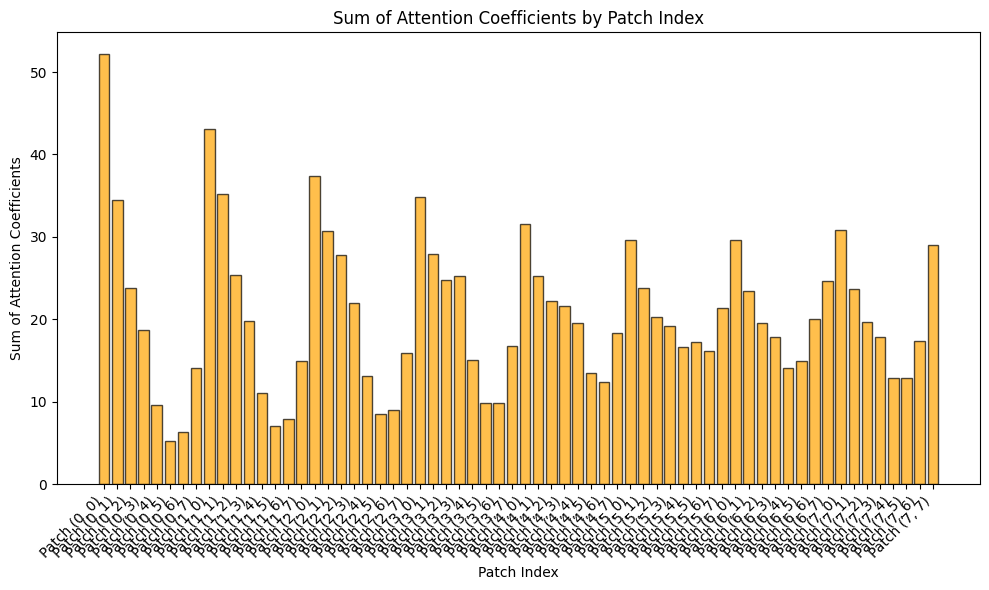

 85%|████████▌ | 17/20 [00:07<00:01,  2.29it/s]

tensor([7, 9, 7, 9, 7, 3, 9, 9, 7, 7, 7, 3, 7, 9, 7, 7, 3, 7, 7, 7, 3, 7, 7, 7,
        7, 1, 3, 9, 7, 9, 3, 7, 0, 9, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9,
        7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 3, 7, 9, 7, 7, 7, 9, 7, 7, 3, 7, 9, 9,
        7, 7, 7, 7, 3, 3, 9, 3, 7, 3, 7, 8, 3, 9, 7, 7, 9, 7, 9, 7, 3, 9, 3, 7,
        3, 7, 7, 7, 7, 3, 7, 3, 9, 7, 9, 7, 3, 9, 7, 7, 7, 9, 7, 7, 9, 7, 7, 7,
        7, 9, 7, 7, 3, 7, 7, 3, 7, 9, 3, 7, 7, 7, 9, 7, 9, 7, 9, 1, 3, 7, 3, 7,
        9, 9, 7, 7, 3, 7, 9, 9, 7, 7, 7, 9, 9, 3, 3, 9, 7, 7, 9, 9, 3, 7, 7, 7,
        7, 7, 7, 7, 7, 9, 9, 3, 7, 3, 3, 7, 9, 9, 3, 9, 9, 9, 7, 7, 7, 9, 7, 9,
        9, 7, 9, 7, 7, 7, 7, 7, 9, 9, 9, 7, 0, 3, 7, 7, 9, 9, 3, 7, 7, 7, 7, 7,
        7, 9, 7, 9, 7, 7, 7, 7, 7, 7, 9, 9, 3, 9, 7, 9, 9, 9, 3, 7, 7, 7, 3, 7,
        9, 7, 3, 3, 7, 3, 9, 9, 7, 4, 7, 9, 7, 7, 9, 9, 9, 7, 7, 9, 7, 9, 3, 7,
        9, 7, 7, 7, 7, 3, 7, 7, 9, 9, 3, 3, 7, 7, 9, 7, 7, 7, 7, 7, 9, 3, 7, 7,
        3, 9, 7, 3, 3, 9, 1, 9, 7, 9, 9,

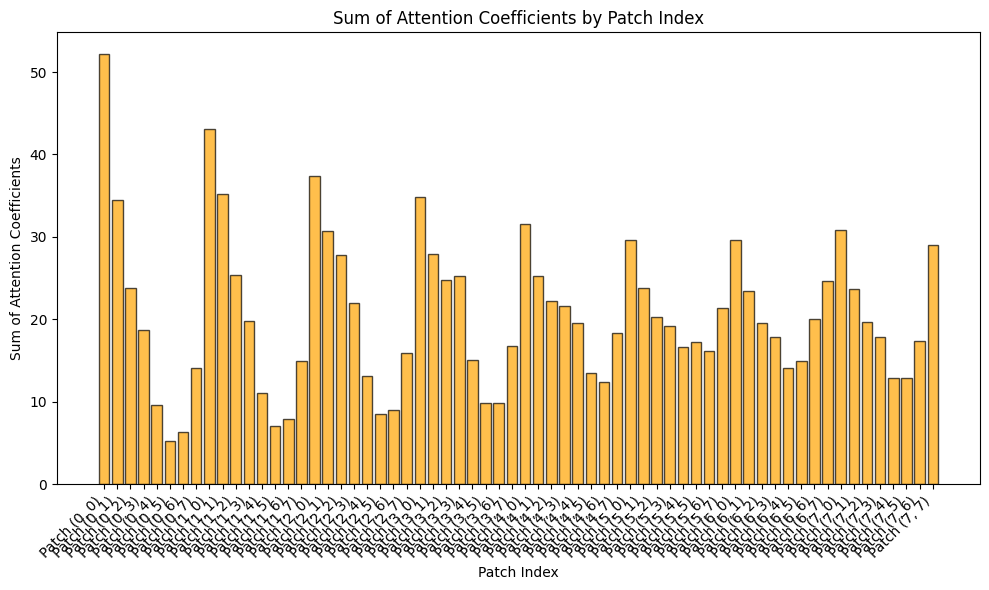

 90%|█████████ | 18/20 [00:08<00:00,  2.30it/s]

tensor([4, 9, 7, 9, 7, 3, 9, 9, 7, 7, 7, 3, 9, 9, 9, 7, 3, 7, 7, 7, 3, 7, 7, 7,
        7, 1, 3, 9, 7, 9, 3, 7, 0, 9, 7, 7, 9, 7, 7, 4, 7, 7, 9, 7, 7, 9, 7, 9,
        7, 7, 7, 7, 7, 7, 9, 1, 7, 7, 7, 4, 7, 9, 7, 7, 7, 9, 9, 7, 3, 7, 9, 9,
        7, 7, 9, 7, 3, 3, 9, 3, 7, 3, 1, 9, 3, 9, 9, 7, 9, 7, 9, 7, 3, 9, 3, 7,
        3, 7, 7, 7, 9, 3, 7, 3, 9, 4, 9, 7, 3, 9, 7, 9, 7, 9, 7, 7, 9, 7, 7, 1,
        9, 9, 7, 7, 3, 7, 1, 3, 7, 9, 3, 7, 7, 7, 9, 7, 9, 7, 9, 1, 3, 7, 3, 7,
        9, 9, 7, 7, 3, 7, 9, 9, 7, 7, 7, 9, 9, 3, 3, 9, 7, 7, 9, 9, 3, 7, 7, 7,
        7, 7, 1, 7, 7, 9, 9, 3, 1, 3, 3, 7, 9, 9, 3, 9, 9, 9, 7, 7, 7, 9, 4, 9,
        9, 4, 9, 7, 7, 7, 7, 7, 9, 9, 9, 1, 0, 3, 1, 7, 9, 9, 3, 7, 7, 8, 7, 7,
        7, 9, 7, 9, 7, 7, 7, 7, 7, 7, 9, 9, 3, 9, 7, 9, 9, 9, 3, 1, 1, 7, 3, 7,
        9, 1, 3, 4, 9, 3, 9, 9, 1, 4, 7, 9, 7, 7, 9, 9, 9, 7, 7, 9, 7, 9, 3, 4,
        9, 7, 7, 7, 9, 3, 7, 9, 9, 9, 3, 3, 7, 7, 9, 7, 7, 7, 7, 7, 9, 3, 7, 7,
        3, 9, 7, 3, 3, 9, 1, 9, 7, 9, 9,

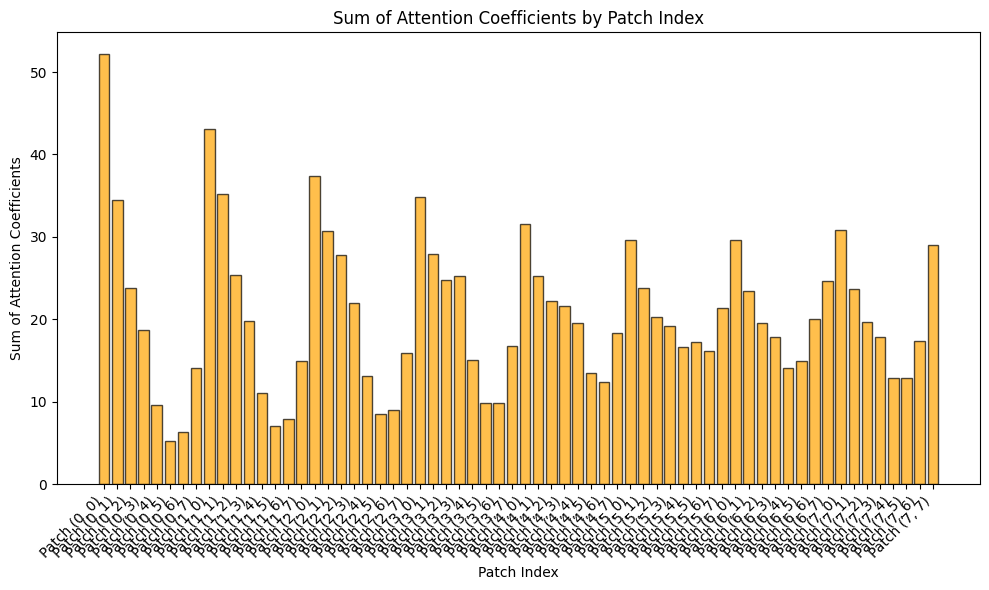

 95%|█████████▌| 19/20 [00:09<00:00,  1.70it/s]

tensor([4, 9, 4, 9, 4, 3, 9, 9, 4, 4, 4, 3, 9, 9, 9, 4, 3, 4, 4, 4, 3, 4, 9, 7,
        7, 4, 3, 9, 4, 9, 3, 7, 9, 9, 4, 4, 9, 4, 7, 4, 4, 4, 9, 4, 4, 9, 4, 9,
        7, 4, 7, 7, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 9, 9, 4, 3, 9, 9, 9,
        9, 4, 9, 4, 3, 3, 9, 3, 7, 3, 4, 9, 3, 9, 9, 4, 9, 4, 9, 4, 3, 9, 3, 4,
        3, 4, 7, 4, 9, 3, 7, 3, 9, 4, 9, 7, 3, 9, 4, 9, 4, 9, 4, 7, 9, 4, 4, 4,
        9, 9, 4, 4, 3, 7, 4, 3, 7, 9, 3, 7, 7, 4, 9, 4, 9, 7, 9, 5, 3, 7, 3, 7,
        9, 9, 4, 7, 3, 4, 9, 9, 9, 4, 4, 9, 9, 3, 3, 9, 7, 4, 9, 9, 3, 4, 4, 7,
        4, 4, 4, 4, 4, 9, 9, 3, 4, 4, 3, 4, 9, 9, 3, 9, 9, 9, 7, 4, 7, 9, 4, 9,
        9, 4, 9, 4, 4, 4, 4, 7, 9, 9, 9, 4, 9, 3, 4, 4, 9, 9, 3, 4, 4, 8, 9, 7,
        4, 9, 4, 9, 4, 4, 9, 7, 9, 4, 9, 9, 3, 9, 7, 9, 9, 9, 3, 4, 4, 4, 3, 4,
        9, 4, 3, 4, 9, 3, 9, 9, 4, 4, 4, 9, 4, 9, 9, 9, 9, 7, 7, 9, 7, 9, 3, 4,
        9, 4, 7, 7, 9, 3, 7, 9, 9, 9, 3, 4, 7, 7, 9, 7, 4, 7, 4, 4, 9, 3, 4, 7,
        3, 9, 7, 3, 3, 9, 4, 9, 7, 9, 9,

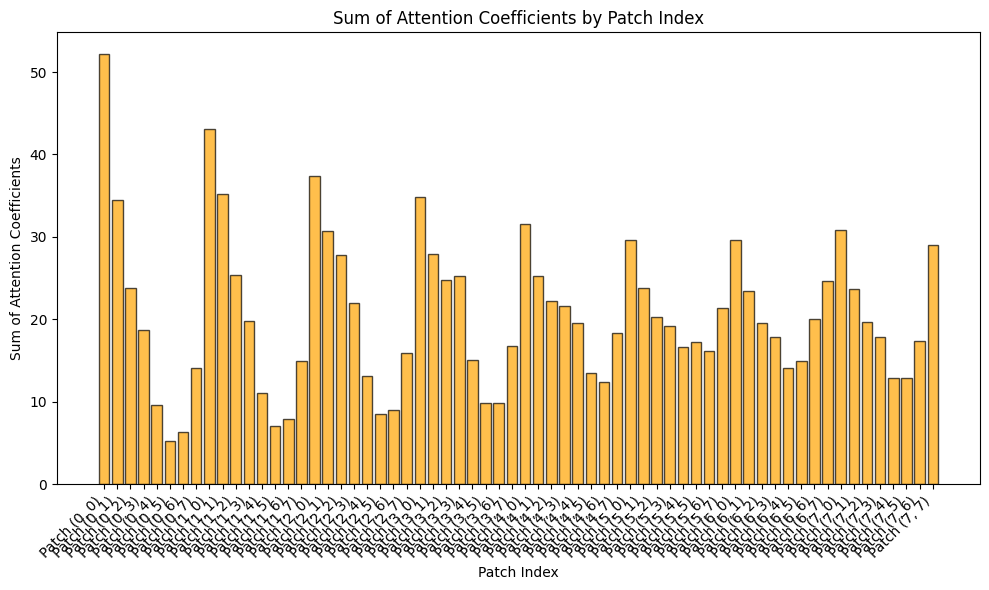

100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

tensor([4, 9, 4, 9, 4, 3, 9, 9, 4, 4, 4, 3, 9, 9, 9, 4, 3, 4, 4, 4, 4, 4, 4, 7,
        4, 4, 3, 9, 4, 9, 3, 4, 9, 9, 4, 4, 9, 4, 4, 4, 4, 4, 9, 4, 4, 9, 4, 9,
        4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 9, 9, 4, 3, 4, 9, 9,
        9, 4, 9, 4, 3, 3, 9, 3, 4, 3, 4, 8, 3, 9, 9, 4, 9, 4, 9, 4, 3, 9, 3, 4,
        3, 4, 7, 4, 9, 3, 4, 3, 9, 4, 9, 9, 3, 9, 4, 9, 4, 9, 4, 4, 9, 4, 4, 4,
        9, 9, 4, 4, 3, 4, 4, 3, 4, 9, 3, 4, 4, 4, 9, 4, 9, 4, 9, 5, 3, 4, 3, 7,
        9, 9, 4, 4, 4, 4, 9, 9, 9, 4, 4, 9, 9, 3, 3, 9, 4, 4, 9, 9, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 9, 9, 3, 4, 4, 4, 4, 9, 9, 3, 9, 9, 9, 4, 4, 4, 9, 4, 9,
        9, 4, 9, 4, 4, 4, 4, 4, 9, 9, 9, 4, 9, 3, 4, 4, 9, 9, 3, 4, 4, 4, 4, 4,
        4, 9, 4, 9, 4, 4, 9, 7, 4, 4, 9, 9, 3, 9, 7, 9, 9, 9, 3, 4, 4, 4, 3, 4,
        9, 4, 3, 4, 4, 3, 9, 9, 4, 4, 4, 9, 4, 4, 9, 9, 9, 4, 4, 9, 4, 9, 3, 4,
        9, 4, 4, 4, 9, 3, 4, 9, 9, 9, 3, 4, 4, 9, 9, 7, 4, 4, 4, 4, 9, 3, 4, 4,
        3, 9, 4, 3, 3, 9, 4, 9, 4, 9, 9,

In [42]:
for iepoch in tqdm(range(20)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = multi_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()

shape torch.Size([80, 2, 64, 64])


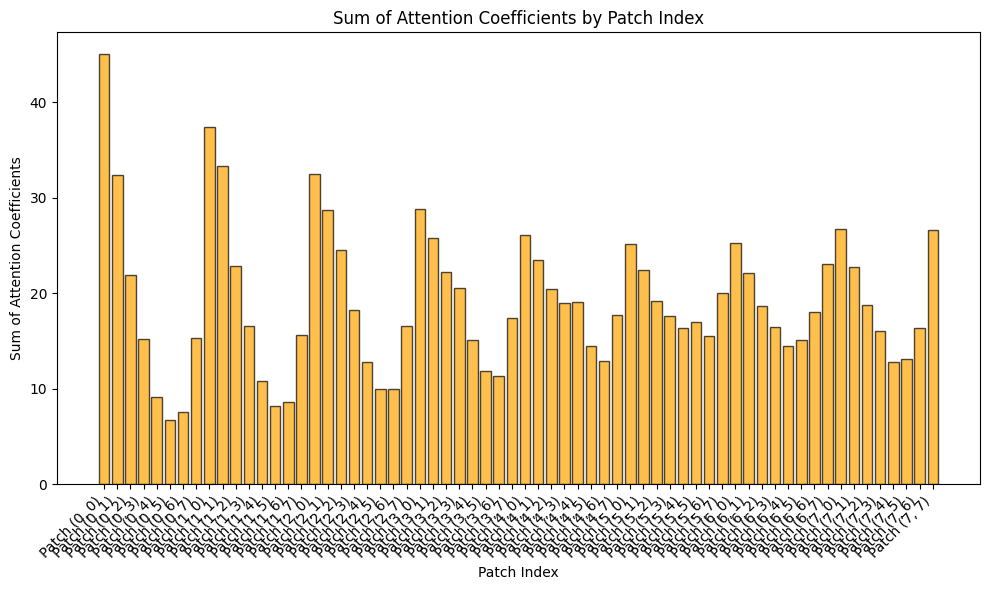

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 3, 3, 4, 4, 4, 9, 8, 4, 4, 9,
        4, 8, 8, 4, 4, 7, 4, 4, 4, 4, 9, 4, 4, 4, 9, 4, 4, 3, 4, 9, 9, 4, 4, 9,
        4, 4, 4, 4, 4, 9, 9, 4, 4, 4, 4, 4, 3, 3, 9, 9, 4, 4, 4, 4, 4, 9, 3, 3,
        3, 9, 4, 9, 9, 9, 8, 9])
tensor([9., 4., 3., 3., 4., 8., 6., 7., 2., 5., 2., 7., 8., 1., 6., 5., 4., 6.,
        1., 9., 5., 7., 0., 9., 0., 1., 9., 7., 0., 9., 7., 5., 6., 1., 1., 6.,
        7., 2., 5., 9., 5., 4., 3., 0., 4., 6., 4., 8., 2., 3., 9., 6., 2., 0.,
        4., 5., 4., 8., 1., 8., 3., 7., 2., 9., 7., 3., 1., 6., 2., 8., 4., 0.,
        3., 7., 1., 8., 3., 5., 8., 0.], dtype=torch.float64)

Accuracy: 0.13750000298023224

AUROC: 0.5997802453993366

Precision (macro): 0.07785114045618248

Recall (macro): 0.13055555555555556

F1 Score (macro): 0.08290804597701149

AUPRC (macro): 0.17751438035521233



/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test, dtype=torch.float32)
predictions = model(X_tensor)

# Convert y_train to tensor and change labels from 1 to 0, and 7 to 1
label=torch.tensor(y_test)
# label = torch.tensor(y_test, dtype=torch.long).clone()  # Ensure labels are LongTensor
        
# Compute loss
loss = criterion(predictions, label)

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Get predicted classes
predicted_classes = np.argmax(preds_np, axis=1)

# Calculate Accuracy
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC for each class (one-vs-rest approach)
auroc = roc_auc_score(labels_np, preds_np, multi_class="ovr")

# Ensure labels_np is in class label form, not one-hot encoded
if labels_np.ndim > 1:
    labels_np = np.argmax(labels_np, axis=1)


# Calculate Precision, Recall, and F1 Score (macro average for multi-class)
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predicted_classes, average='macro')

# Calculate AUPRC (Area Under the Precision-Recall Curve) for each class
auprc = average_precision_score(labels_np, preds_np, average="macro")

# Print results
print(f'\nAccuracy: {acc}\n')
# print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision (macro): {precision}\n')
print(f'Recall (macro): {recall}\n')
print(f'F1 Score (macro): {f1}\n')
print(f'AUPRC (macro): {auprc}\n')